In [11]:
import pandas as pd
import numpy as np
import itertools
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt

In [12]:
# Extracting and Exploring Data
df = pd.read_csv('train.csv')
print("Shape is: " , df.shape)
print(df.head(3))

Shape is:  (20800, 5)
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  


In [13]:
# Prepare the data by adjusting id and filling empty columns
# Change index to given one
df = df.set_index('id')
# Fill empty columns with ''
df= df.fillna(' ')

# Replace nan with ''
df['title'] = df['title'].replace('nan',' ')
df['text'] = df['text'].replace('nan',' ')
df['author'] = df['author'].replace('nan',' ')

# Feature Engineering
# Change athor to true (1) or false(0) first
df.loc[df.author != ' ', 'author'] = True
df.loc[df.author == ' ', 'author'] = False

# Cleaning more noise within the text
# Change text to lowercase to prevent multiple copies of the same word: 'And' vs 'and'
df['title'] = df['title'].apply(lambda x:" ".join(x.lower() for x in x.split()))
df['text'] = df['text'].apply(lambda x:" ".join(x.lower() for x in x.split()))
# Remove punctuations as they are extra information when treating data
df['title'] = df['title'].str.replace('[^\w\s]','')
df['text'] = df['text'].str.replace('[^\w\s]','')
    
df.head()

,title,author,text,label
id,,,,
0,house dem aide we didnt even see comeys letter...,True,house dem aide we didnt even see comeys letter...,1
1,flynn hillary clinton big woman on campus bre...,True,ever get the feeling your life circles the rou...,0
2,why the truth might get you fired,True,why the truth might get you fired october 29 2...,1
3,15 civilians killed in single us airstrike hav...,True,videos 15 civilians killed in single us airstr...,1
4,iranian woman jailed for fictional unpublished...,True,print an iranian woman has been sentenced to s...,1


In [14]:
# Remove commonly recurring words in text which are extra noise inside column text
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
print(freq)
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

the     919621
to      425565
of      417823
and     381699
a       366144
in      310111
that    210357
is      156676
for     144410
on      130453
dtype: int64


id
0    house dem aide we didnt even see comeys letter...
1    ever get feeling your life circles roundabout ...
2    why truth might get you fired october 29 2016 ...
3    videos 15 civilians killed single us airstrike...
4    print an iranian woman has been sentenced six ...
Name: text, dtype: object

In [15]:
# Remove rare words in text which are extra noise inside column text
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
print(freq)
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

desplazado          1
subaccounts         1
snowdenopponents    1
بناءة               1
тренером            1
8848958             1
superflossers       1
pelochas            1
dhl                 1
ruhl                1
dtype: int64


id
0    house dem aide we didnt even see comeys letter...
1    ever get feeling your life circles roundabout ...
2    why truth might get you fired october 29 2016 ...
3    videos 15 civilians killed single us airstrike...
4    print an iranian woman has been sentenced six ...
Name: text, dtype: object

In [27]:
# Shuffle data
df.reindex(np.random.permutation(df.index))

# Split Train Test feature
df_label = pd.DataFrame(df, columns=['label'])
df_feature = pd.DataFrame(df, columns=['text','title','author'])
x_train, x_test, y_train, y_test = train_test_split(df_feature.values, df_label.values, test_size=0.3, random_state=7)

In [17]:
# Defining countvectorizer (Stop_words remove reoccuring words that are useless)
tfidf_vectorizer1 = TfidfVectorizer(stop_words='english')
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english')

# Extract column from DataFrame
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameColumnExtracter(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# CountVectorizer the 2 features. Own tfidf for better accuracy with individual vocabulary dict
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
text_pipe = make_pipeline(
       DataFrameColumnExtracter('text'), 
       tfidf_vectorizer1
)

title_pipe = make_pipeline(
       DataFrameColumnExtracter('title'), 
       tfidf_vectorizer2
)

# Combining the 2 pipes so it acts as a single function to convert the features DataFrame to int
feature_union = make_union(text_pipe, title_pipe)


In [52]:
# Prepare the new data and applying dataframe on them
tfidf_x_train = pd.DataFrame(x_train,columns=['text','title','author'])
temp_train = tfidf_x_train[['text','title']]
temp_train_author = tfidf_x_train[['author']]
new_y_train = pd.DataFrame(y_train, columns=['label'])

tfidf_x_test = pd.DataFrame(x_test,columns=['text','title','author'])
temp_test = tfidf_x_test[['text','title']]
temp_test_author = tfidf_x_test[['author']]
new_y_test = pd.DataFrame(y_test, columns=['label'])

# Change Input to be Int Matrix for Machine to Read (Training)
new_x_train = feature_union.fit_transform(temp_train.astype("U"))

# Change Input to be Int Matrix for Machine to Read (Test)
new_x_test = feature_union.transform(temp_test.astype("U"))

In [54]:
print(new_x_train.shape)
print(new_x_test.shape)

(14560, 193658)
(6240, 193658)


In [55]:
# Joining all the features back together
from scipy.sparse import hstack
new_x_train = hstack((new_x_train, np.array(temp_train_author['author'].astype(float))[:,None]))
new_x_test = hstack((new_x_test, np.array(temp_test_author['author'].astype(float))[:,None]))

In [56]:
print(new_x_train.shape)
print(new_x_test.shape)

(14560, 193659)
(6240, 193659)


In [57]:
# Test options and evaluation 
seed = 7 
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', MultinomialNB()))
models.append(('DTC', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:	
    kfold = model_selection.KFold(n_splits=10, random_state=seed)	
    cv_results = model_selection.cross_val_score(model, new_x_train, new_y_train.values.ravel(), cv=kfold, scoring=scoring)       
    results.append(cv_results)	
    names.append(name)	
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())	
    print(msg)


LR: 0.972390 (0.004666)
KNN: 0.594849 (0.011157)
NB: 0.856319 (0.009866)
DTC: 0.963324 (0.003936)


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\Timothy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy:   0.975480769
Confusion matrix, without normalization


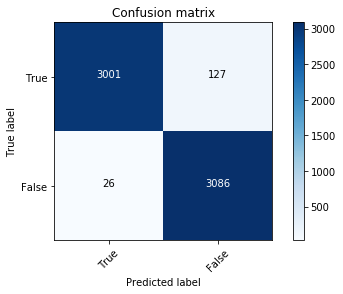

In [58]:
# Predicting accuracy for LR against Test
modelLR = LogisticRegression()
modelLR.fit(new_x_train, new_y_train.values.ravel())
predLR = modelLR.predict(new_x_test)
scoreLR = metrics.accuracy_score(new_y_test, predLR)
print("accuracy:   %0.9f" % scoreLR)

# LR confusion Matrix
cmLR = metrics.confusion_matrix(new_y_test, predLR)
plot_confusion_matrix(cmLR, classes=["True", "False"])

accuracy:   0.959615385
Confusion matrix, without normalization


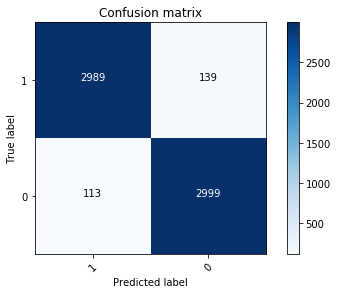

In [8]:
# Predicting accuracy for DTC against Test
modelDTC = DecisionTreeClassifier()
modelDTC.fit(sparse_matrix_of_counts, df_y_train.values.ravel())
predDTC = modelDTC.predict(sparse_matrix_of_counts2)
scoreDTC = metrics.accuracy_score(df_y_test, predDTC)
print("accuracy:   %0.9f" % scoreDTC)

# DTC confusion Matrix
cmDTC = metrics.confusion_matrix(df_y_test, predDTC)
plot_confusion_matrix(cmDTC, classes=["True", "False"])

In [61]:
#Fit regression model
model = LogisticRegression()
# Parameters we want to try
param_grid = [
    {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
]

# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(model, param_grid, n_jobs=1, verbose=100)

# Run the grid search - on only the training data!
gs_cv.fit(new_x_train, new_y_train.values.ravel())

# Print the parameters that gave us the best result!
print(gs_cv.best_params_)

# Find the error rate on the training set using the best parameters
mse = mean_absolute_error(new_y_train, gs_cv.predict(new_x_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
mse = mean_absolute_error(new_y_test, gs_cv.predict(new_x_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

# Final Result:
# {'C': 1000}
# Training Set Mean Absolute Error: 0.0000
# Test Set Mean Absolute Error: 0.0173

C:\Users\Timothy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Timothy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.5877626699629172, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.5945611866501854, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] C=0.001 .........................................................
[CV] ................. C=0.001, score=0.591714756801319, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9460238978162341, total=   0.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

C:\Users\Timothy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy:   0.982692308
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3128
           1       0.97      0.99      0.98      3112

   micro avg       0.98      0.98      0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240

Confusion matrix, without normalization


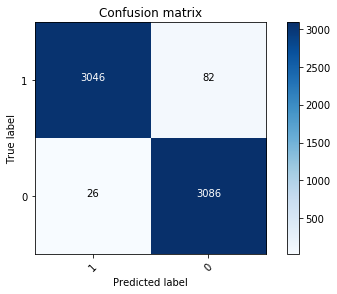

In [65]:
# Predicting accuracy for grid-tested LR against Test
modelLR = LogisticRegression(C= 1000)
modelLR.fit(new_x_train, new_y_train.values.ravel())
predLR = modelLR.predict(new_x_test)
scoreLR = metrics.accuracy_score(new_y_test, predLR)
print("accuracy:   %0.9f" % scoreLR)
print("Classification report:")
print(classification_report(new_y_test, predLR))

# LR confusion Matrix
cmLR = metrics.confusion_matrix(new_y_test, predLR)
plot_confusion_matrix(cmLR, classes=["1", "0"])

In [66]:
#Fit decision tree classifier model
model2 = DecisionTreeClassifier()
# Parameters we want to try
param_grid = [
    {
        'max_depth': [8, 10, 20],
        'min_samples_split' : [10, 25, 50, 100],
        'min_samples_leaf': [5, 9, 17],
        'max_features': [1.0]
}
]
# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(model2, param_grid, n_jobs=1, verbose=100)

# Run the grid search - on only the training data!
gs_cv.fit(new_x_train, new_y_train.values.ravel())

# Print the parameters that gave us the best result!
print(gs_cv.best_params_)

# Find the error rate on the training set using the best parameters
mse = mean_absolute_error(new_y_train, gs_cv.predict(new_x_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
mse = mean_absolute_error(new_y_test, gs_cv.predict(new_x_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

# Final Result: 
# {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 5, 'min_samples_split': 10}
# Training Set Mean Absolute Error: 0.0241
# Test Set Mean Absolute Error: 0.0333

C:\Users\Timothy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10, score=0.9686856201071281, total=   4.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[CV] max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10, score=0.9668314791924186, total=   4.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s
[CV] max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=10, score=0.9614591920857378, total=   4.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[CV] max_depth=8, max_feat

accuracy:   0.966666667
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3128
           1       0.95      0.99      0.97      3112

   micro avg       0.97      0.97      0.97      6240
   macro avg       0.97      0.97      0.97      6240
weighted avg       0.97      0.97      0.97      6240

Confusion matrix, without normalization


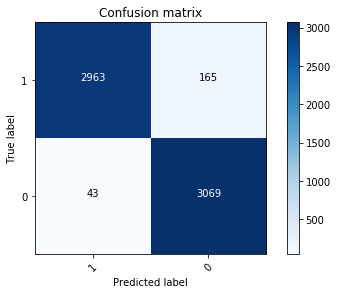

In [67]:
# Predicting accuracy for grid-tested DTC against Test
modelDTC = DecisionTreeClassifier(max_depth= 10, max_features= 1.0, min_samples_leaf= 5, min_samples_split= 10)
modelDTC.fit(new_x_train, new_y_train.values.ravel())
predDTC = modelDTC.predict(new_x_test)
scoreDTC = metrics.accuracy_score(new_y_test, predDTC)
print("accuracy:   %0.9f" % scoreDTC)
print("Classification report:")
print(classification_report(new_y_test, predDTC))
# DTC confusion Matrix
cmDTC = metrics.confusion_matrix(new_y_test, predDTC)
plot_confusion_matrix(cmDTC, classes=["1", "0"])

In [69]:
# Save model pkl
joblib.dump(modelLR, 'models//LR_fake_news_model.pkl')
joblib.dump(modelDTC, 'models//DTC_fake_news_model.pkl')

['models//DTC_fake_news_model.pkl']

In [70]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer1, modelLR)

0 -25.692391414616853 twitter
0 -24.049200375066782 breitbart
0 -23.804386485391856 000
0 -22.865835914210894 said
0 -20.66665437853477 follow
0 -19.97964906670279 2017
0 -18.275509433976087 president
0 -13.068884489860128 com
0 -12.624361239965959 ap
0 -10.731485855216201 reported
0 -10.336764802647005 sunday
0 -10.161585282184053 reports
0 -9.372404761099725 pic
0 -9.34054761723297 jeromeehudson
0 -9.198051036241154 january
0 -9.002772534594916 jerome
0 -8.933377576147324 cent
0 -8.747833816548445 administration
0 -8.637923280442704 texas
0 -8.57800201727495 march
0 -8.270839837276108 hudson
0 -7.634966682862663 islamic
0 -7.367177456461653 saturday
0 -7.363705152866144 added
0 -7.233162918081134 ms
0 -7.187543768661748 siriusxm
0 -7.175020157898098 mr
0 -6.958674143984025 week
0 -6.888197694188638 reportedly
0 -6.6647898206680045 wrote
0 -6.617895796431371 nussbaum
0 -6.516260679272651 dznussbaum
0 -6.386664362489955 actress
0 -6.334720130490285 continued
0 -6.084608659923317 april
